In [13]:

#Q4:WAP to evaluate the performance of implemented three-layer neural network with variations in
#activation functions, size of hidden layer, learning rate, batch size and number of epochs.

#Model Description:- 
#Model Overview
#This model is a binary classification neural network designed to evaluate different hyperparameter configurations. It is implemented using TensorFlow and Keras and is trained on a synthetic dataset generated using sklearn.datasets.make_classification(). The dataset contains 1000 samples with 20 features, and the target variable is binary (0 or 1).

#The model follows a feedforward architecture with three layers:

#Input Layer: Fully connected (Dense) layer with a variable number of neurons (hidden_layer_size) and an activation function (relu, tanh, or sigmoid).
#Hidden Layer: A second Dense layer with hidden_layer_size // 2 neurons (minimum of 1 neuron to prevent invalid configurations) and the same activation function.
#Output Layer: A single neuron with a sigmoid activation function for binary classification.

#Training Process
#The dataset is standardized using StandardScaler to improve training stability.
#The model is compiled using the Adam optimizer, with varying learning rates (0.1, 0.001, and 1.0).
#Binary cross-entropy loss is used, as this is a classification problem.
#The model is trained with different batch sizes (100, 10, 1) and epochs (100, 50, 10) to evaluate performance under different settings.
#Test accuracy is reported for each configuration.



import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Disable eager execution for TF 2.x compatibility with TF 1.x code
tf.compat.v1.disable_eager_execution()

# Generate synthetic dataset (28x28 grayscale images, 10 classes)
def generate_synthetic_dataset(num_samples=10000):
    data = np.random.rand(num_samples, 28 * 28)  # Flattened 28x28 images
    labels = np.random.randint(0, 10, num_samples)  # 10 classes

    # Normalize images
    data = data.astype("float32")

    # One-hot encode labels
    labels = to_categorical(labels, num_classes=10)

    # Split into training and testing sets
    train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=42)

    return train_x, test_x, train_y, test_y

# Load the synthetic dataset
train_x, test_x, train_y, test_y = generate_synthetic_dataset()

# Convert to TensorFlow dataset format
batch_size = 10
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(10000).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size)

# Define placeholders
X = tf.compat.v1.placeholder(tf.float32, shape=[None, 28 * 28])  # Input shape (28x28 flattened)
Y = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])  # 10 classes

# Define network architecture
def create_network(h1, h2):
    weights = {
        "h1": tf.Variable(tf.random.normal([28 * 28, h1])),
        "h2": tf.Variable(tf.random.normal([h1, h2])),
        "out": tf.Variable(tf.random.normal([h2, 10])),
    }
    biases = {
        "b1": tf.Variable(tf.random.normal([h1])),
        "b2": tf.Variable(tf.random.normal([h2])),
        "out": tf.Variable(tf.random.normal([10])),
    }
    return weights, biases

# Forward propagation
def forward_propagation(x, weights, biases):
    layer1 = tf.nn.relu(tf.add(tf.matmul(x, weights["h1"]), biases["b1"]))
    layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, weights["h2"]), biases["b2"]))
    output_layer = tf.add(tf.matmul(layer2, weights["out"]), biases["out"])
    return output_layer

# Training configurations
hidden_layer_configs = [(160, 100), (100, 100), (100, 160), (60,60), (100,60)]
learning_rates = [0.01, 0.1, 1]
num_epochs = 50  

results = []
accuracy_curves = {}
loss_curves = {}
confusion_matrices = {}

with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Build model
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1)), tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            acc_list, loss_list = [], []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss, avg_acc = 0, 0
                for _ in range(len(train_x) // batch_size):
                    batch_x, batch_y = sess.run(next_batch)
                    _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                    avg_loss += l / (len(train_x) // batch_size)
                    avg_acc += acc / (len(train_x) // batch_size)
                
                acc_list.append(avg_acc)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc*100:.2f}%")

            # Evaluate on test data
            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_acc, y_true, y_pred = 0, [], []
            
            sess.run(iterator_test.initializer)
            for _ in range(len(test_x) // batch_size):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_acc += acc / (len(test_x) // batch_size)
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_acc * 100, time.time() - start_time))
            accuracy_curves[(h1, h2, lr)] = acc_list
            loss_curves[(h1, h2, lr)] = loss_list



Training with hidden layers (160, 100) and learning rate 0.01
Epoch 1, Loss: 88.6984, Accuracy: 10.10%
Epoch 2, Loss: 6.9279, Accuracy: 10.18%
Epoch 3, Loss: 5.3569, Accuracy: 10.49%
Epoch 4, Loss: 4.3088, Accuracy: 10.08%
Epoch 5, Loss: 3.8537, Accuracy: 9.75%
Epoch 6, Loss: 2.6935, Accuracy: 10.13%
Epoch 7, Loss: 2.3164, Accuracy: 9.94%
Epoch 8, Loss: 2.3146, Accuracy: 10.16%
Epoch 9, Loss: 2.3160, Accuracy: 9.76%
Epoch 10, Loss: 2.3143, Accuracy: 10.23%
Epoch 11, Loss: 2.3144, Accuracy: 9.60%
Epoch 12, Loss: 2.3135, Accuracy: 10.31%
Epoch 13, Loss: 2.3131, Accuracy: 10.09%
Epoch 14, Loss: 2.3117, Accuracy: 10.25%
Epoch 15, Loss: 2.3084, Accuracy: 10.08%
Epoch 16, Loss: 2.3105, Accuracy: 9.53%
Epoch 17, Loss: 2.3097, Accuracy: 9.85%
Epoch 18, Loss: 2.3079, Accuracy: 9.89%
Epoch 19, Loss: 2.3070, Accuracy: 10.13%
Epoch 20, Loss: 2.3065, Accuracy: 10.16%
Epoch 21, Loss: 2.3063, Accuracy: 9.33%
Epoch 22, Loss: 2.3059, Accuracy: 9.64%
Epoch 23, Loss: 2.3053, Accuracy: 9.93%
Epoch 24, Los

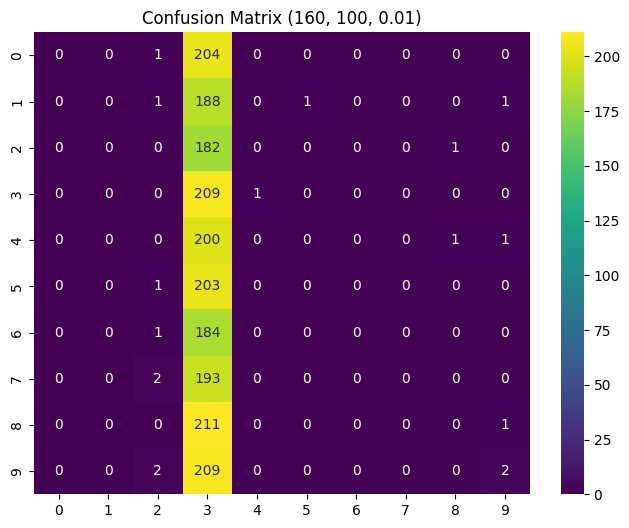

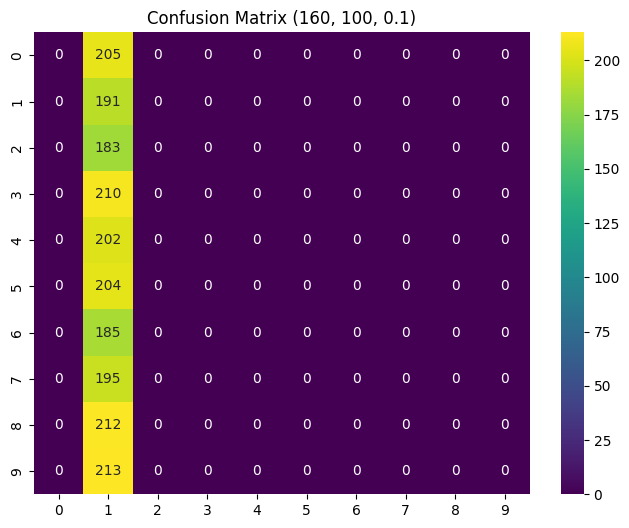

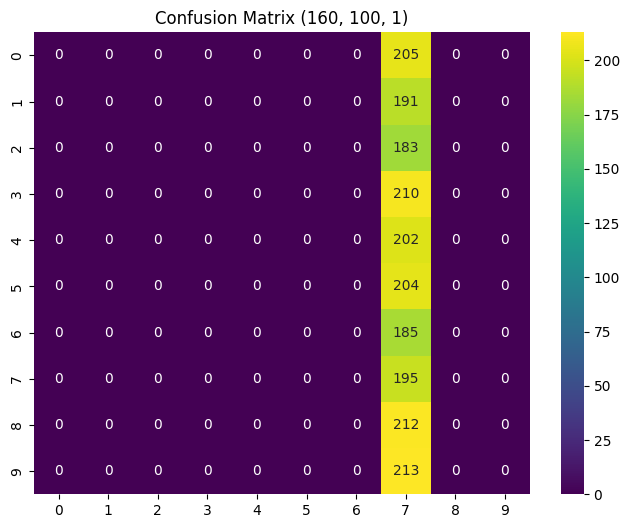

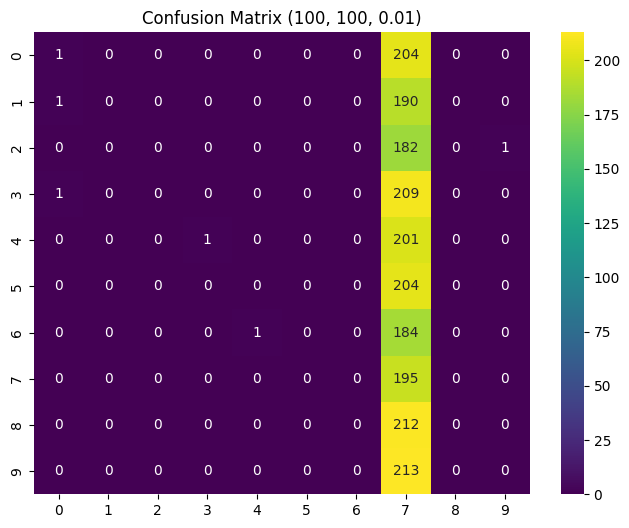

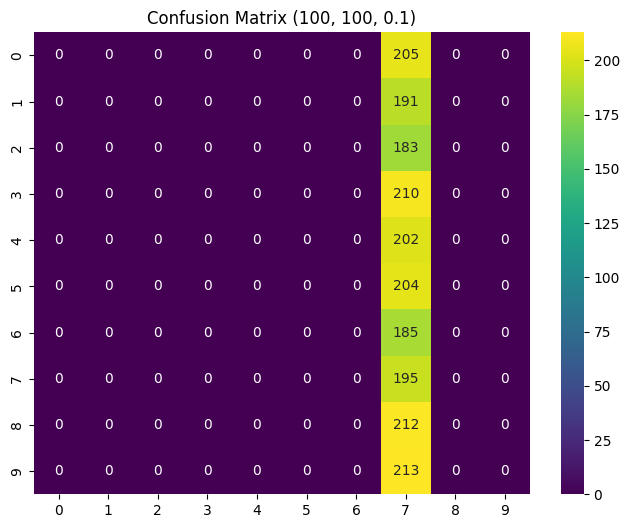

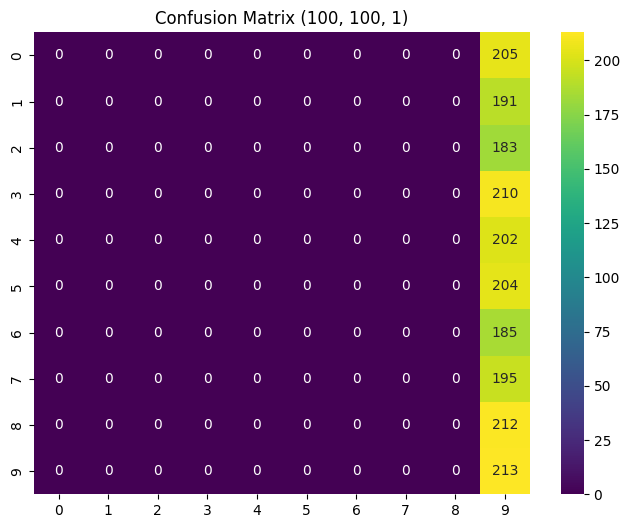

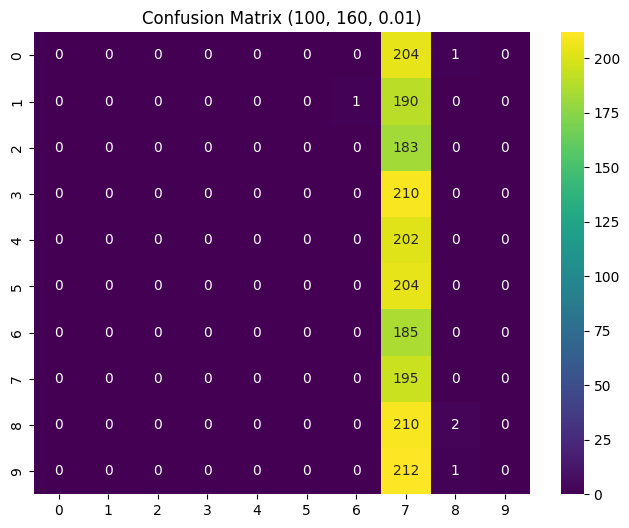

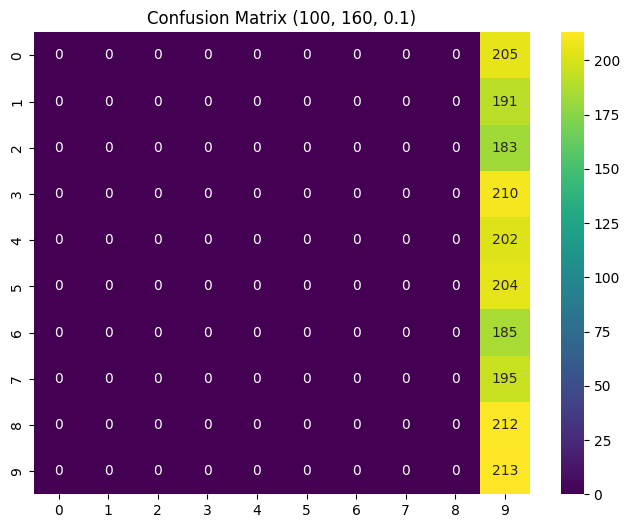

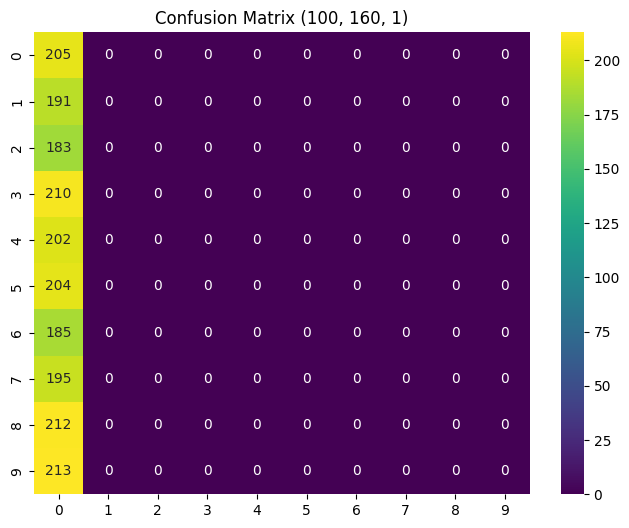

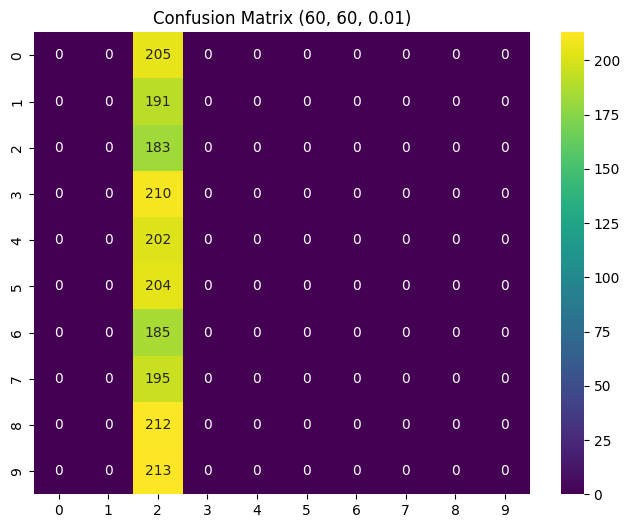

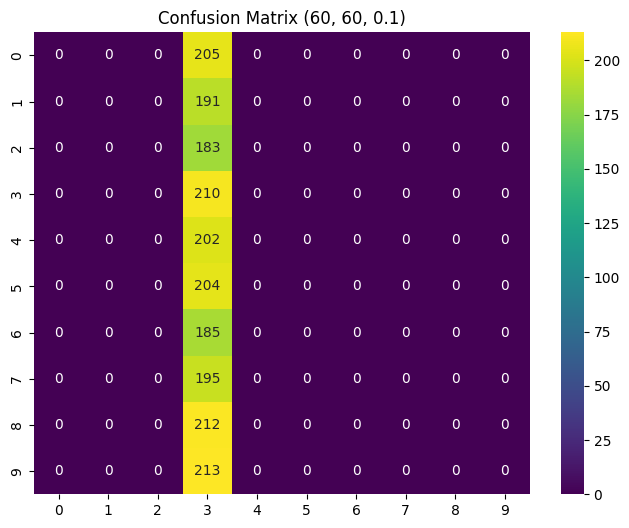

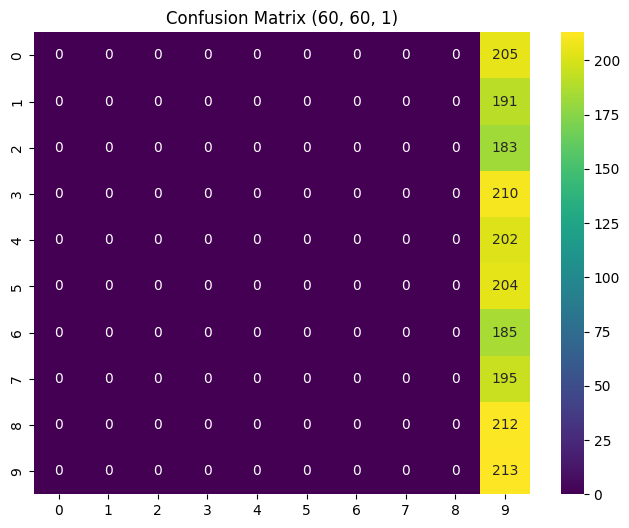

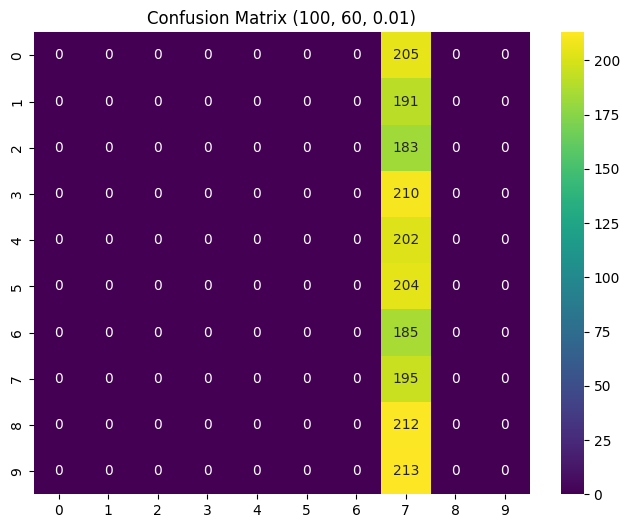

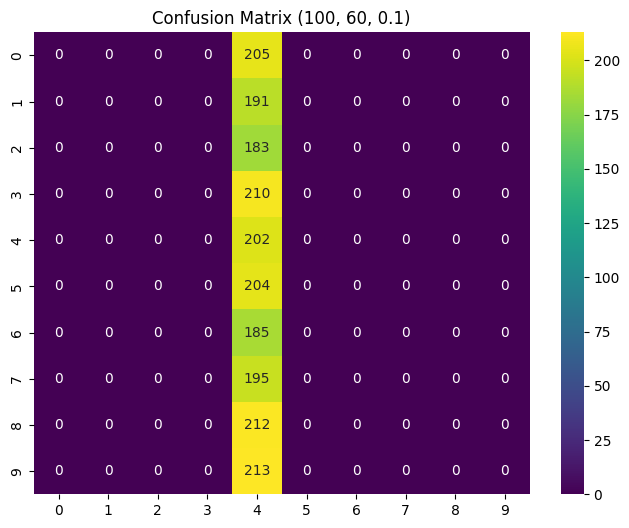

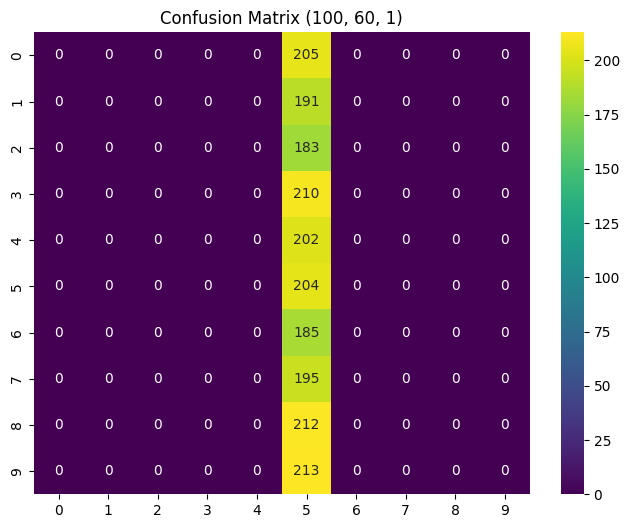

In [7]:
for key in confusion_matrices.keys():
    plt.figure(figsize=(8, 6))  # Adjust size for better readability
    sns.heatmap(confusion_matrices[key], annot=True, cmap="viridis", fmt='d')
    plt.title(f"Confusion Matrix {key}")
    plt.show()


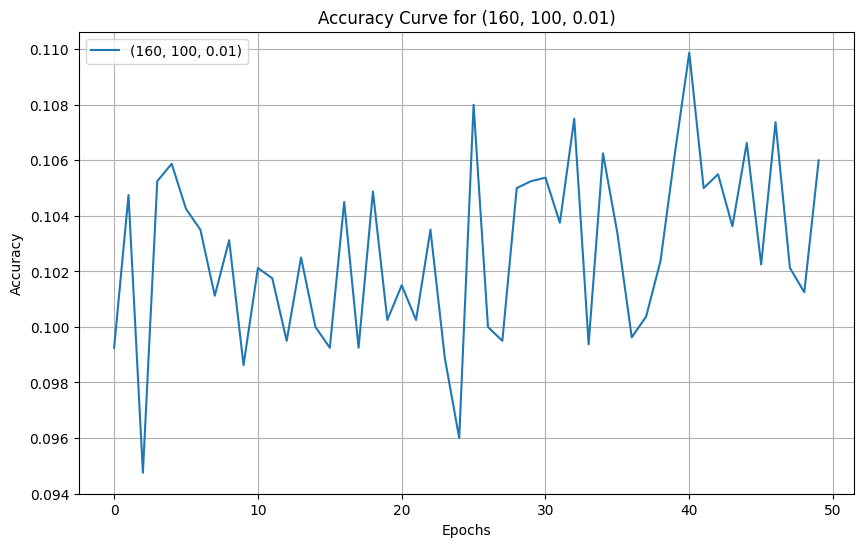

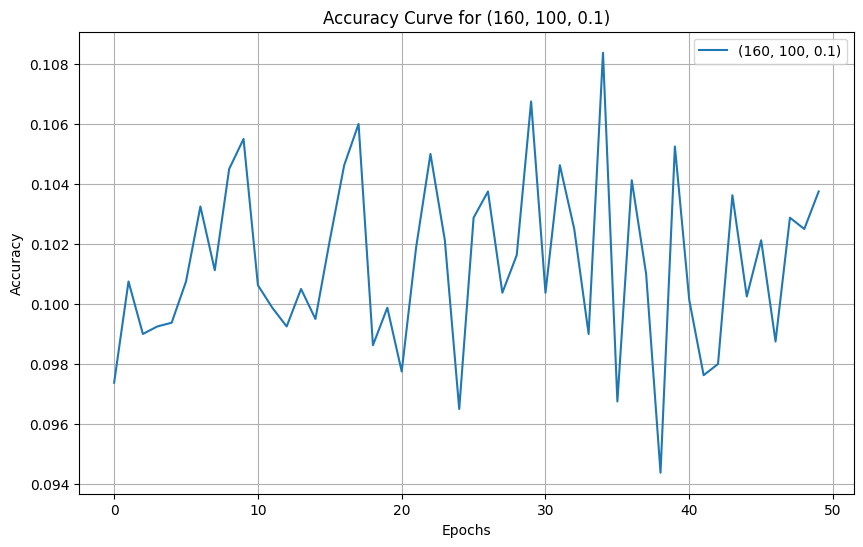

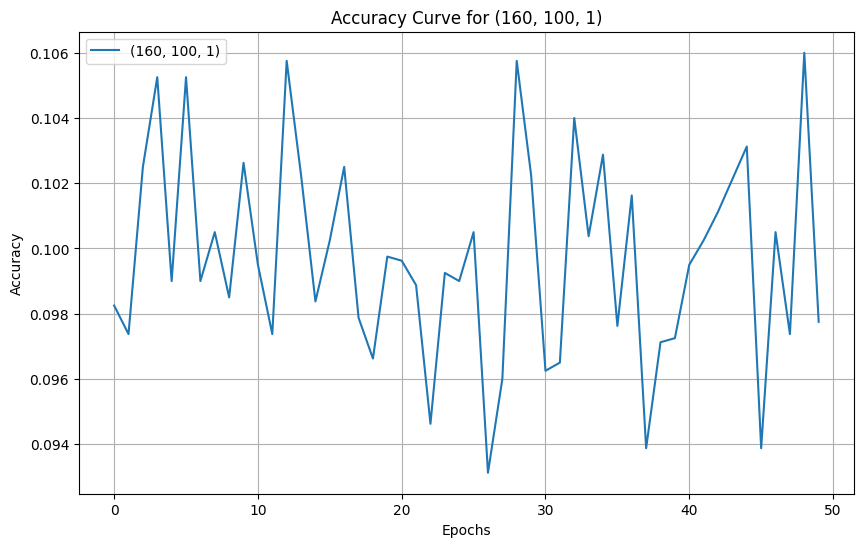

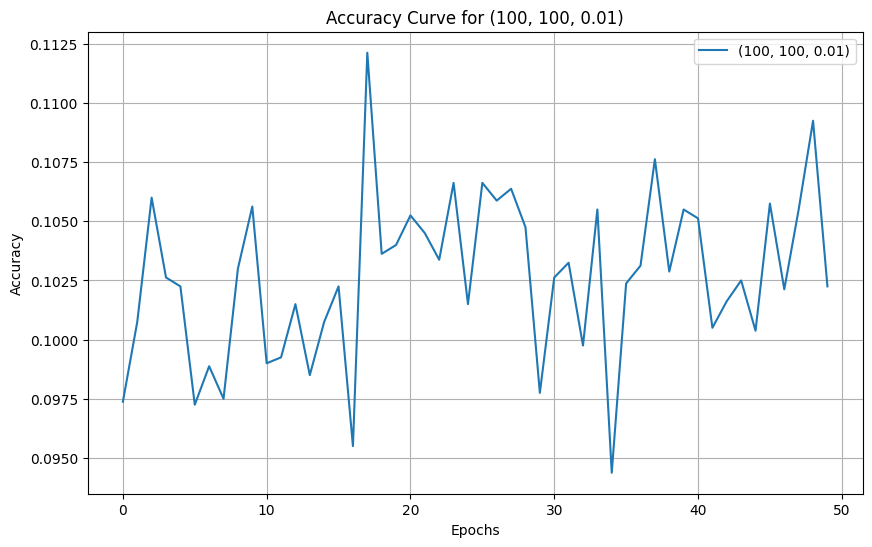

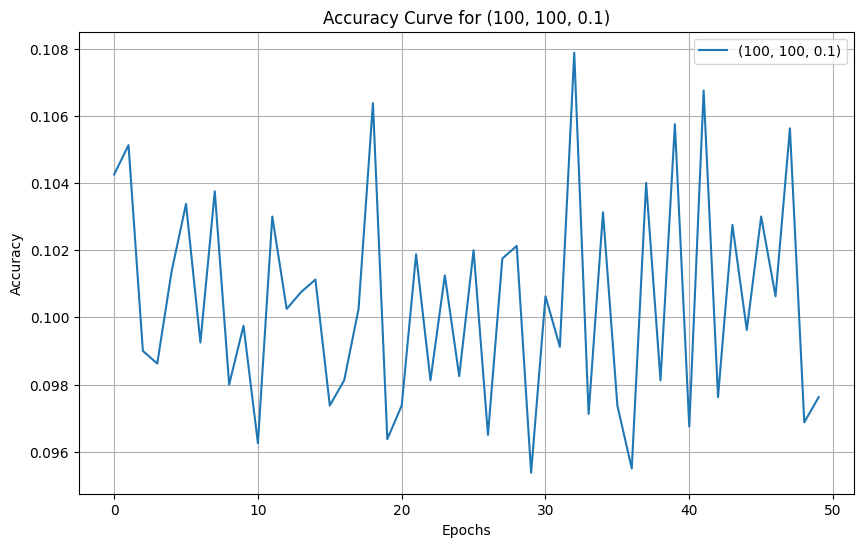

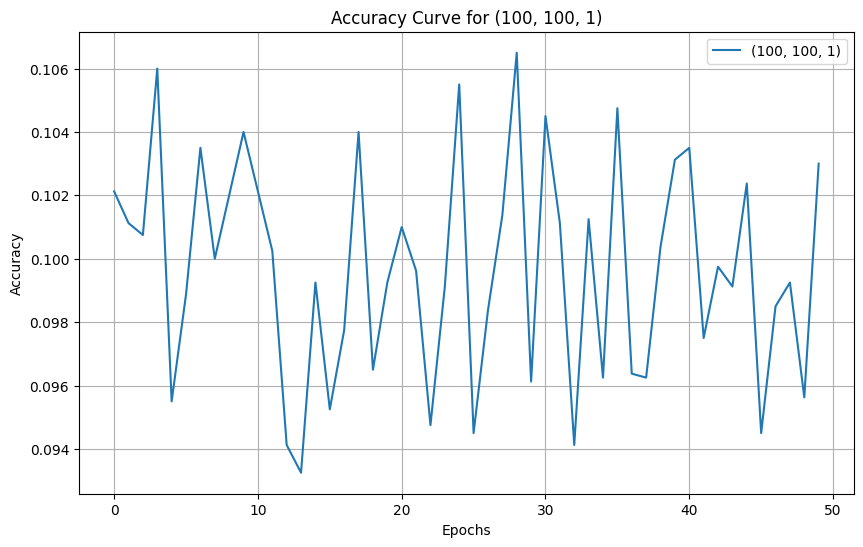

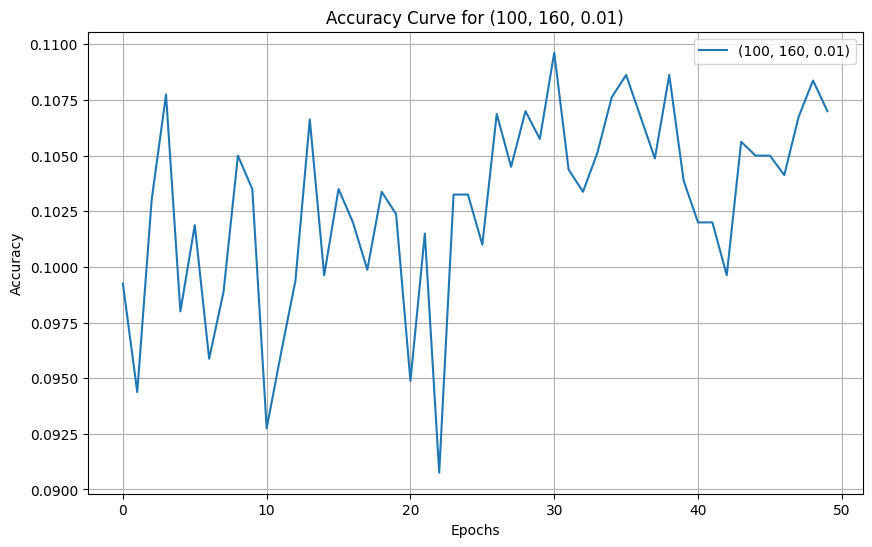

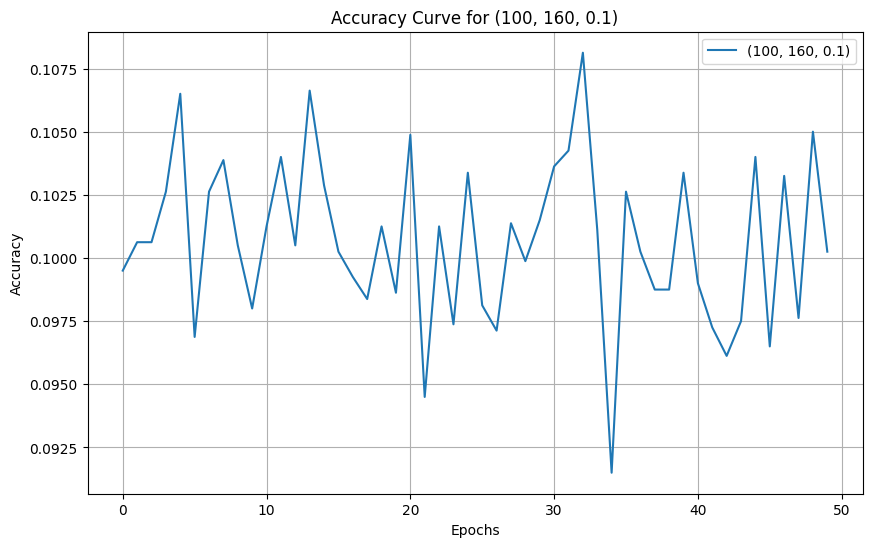

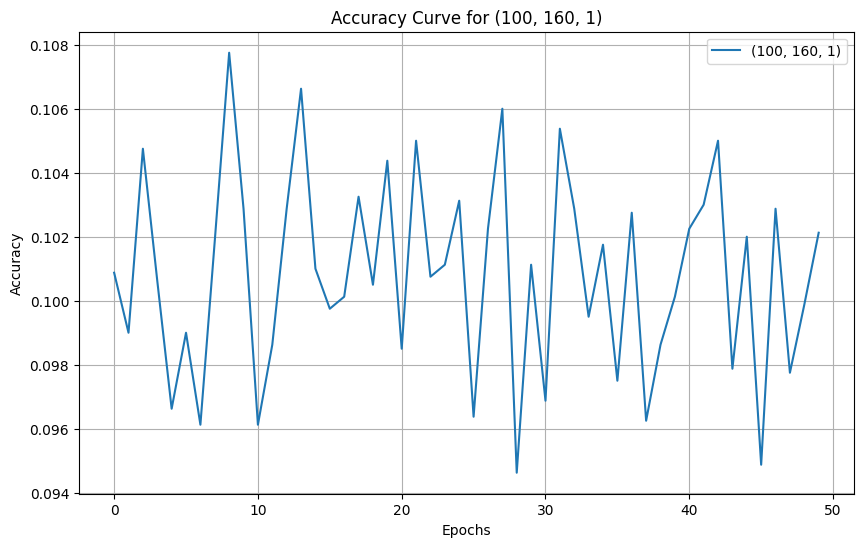

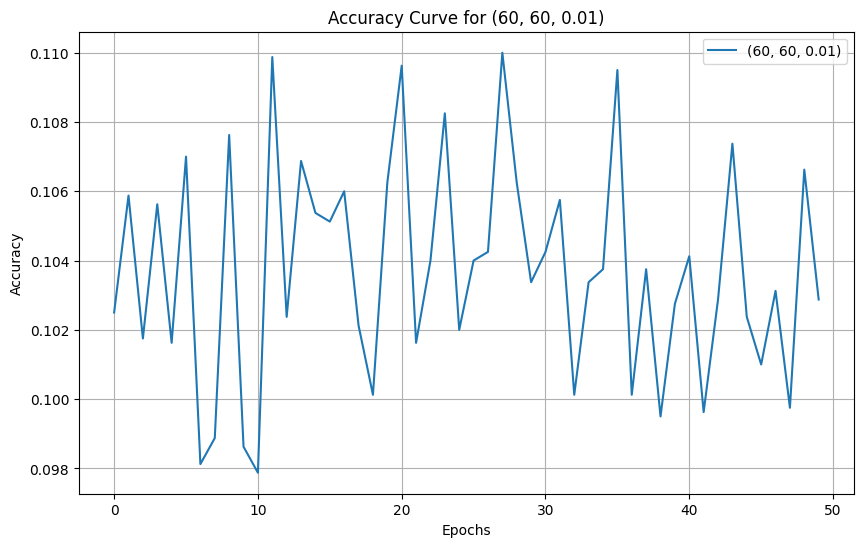

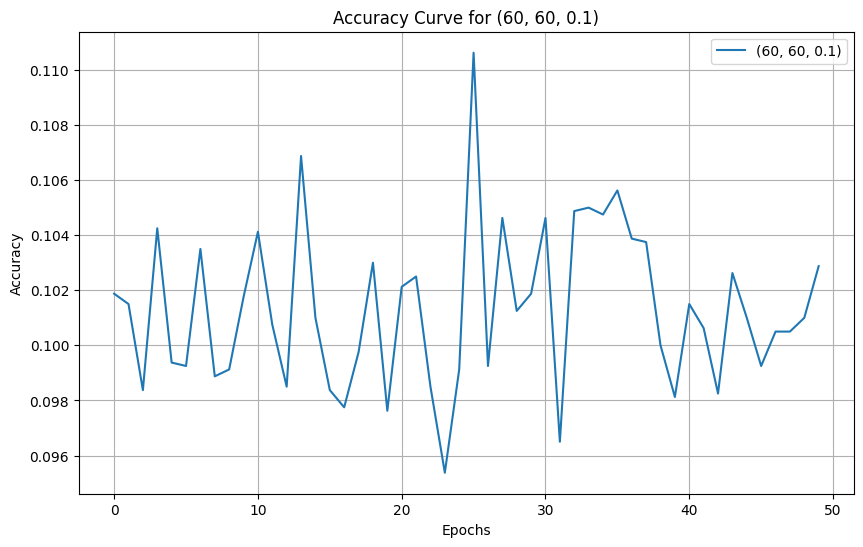

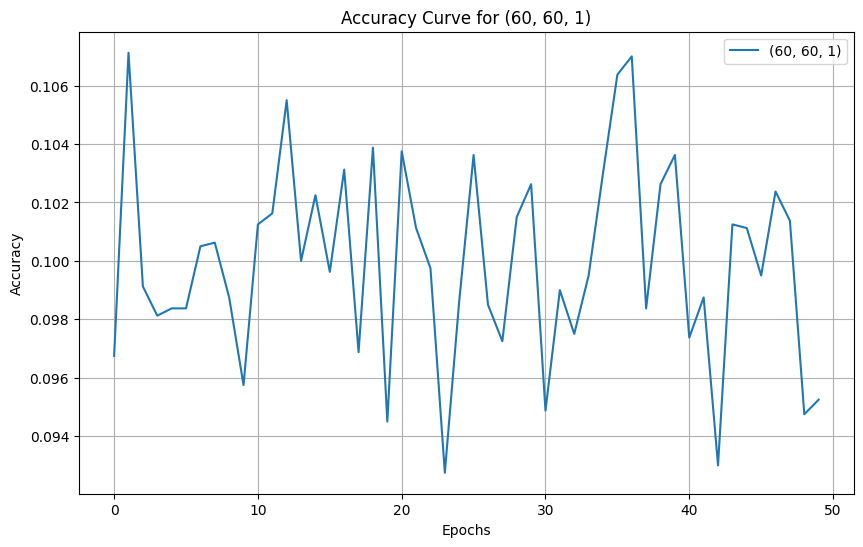

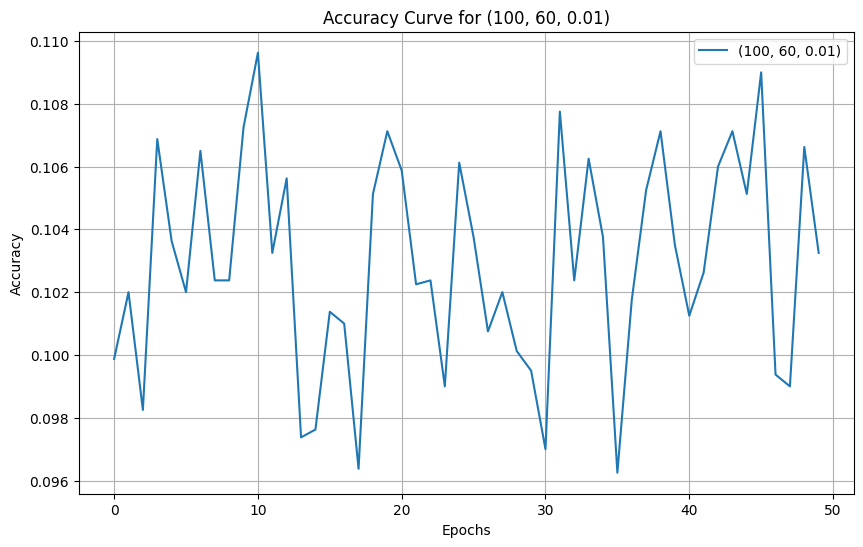

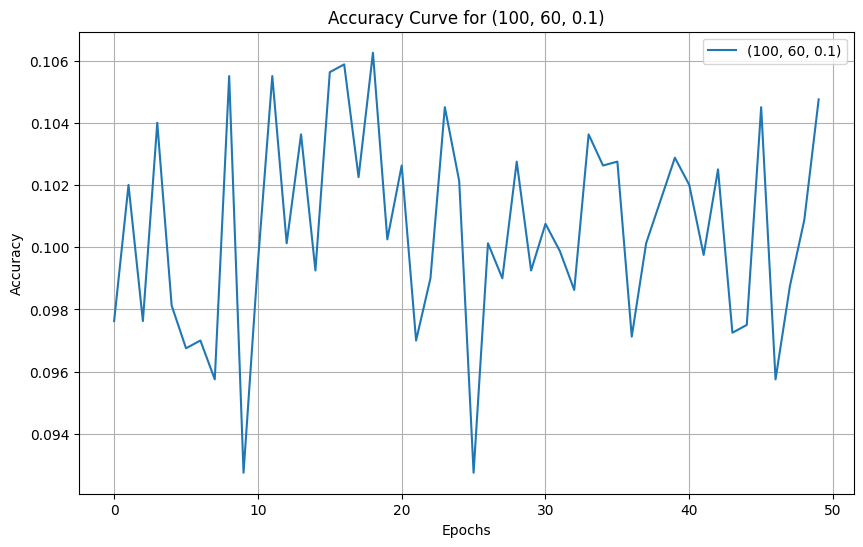

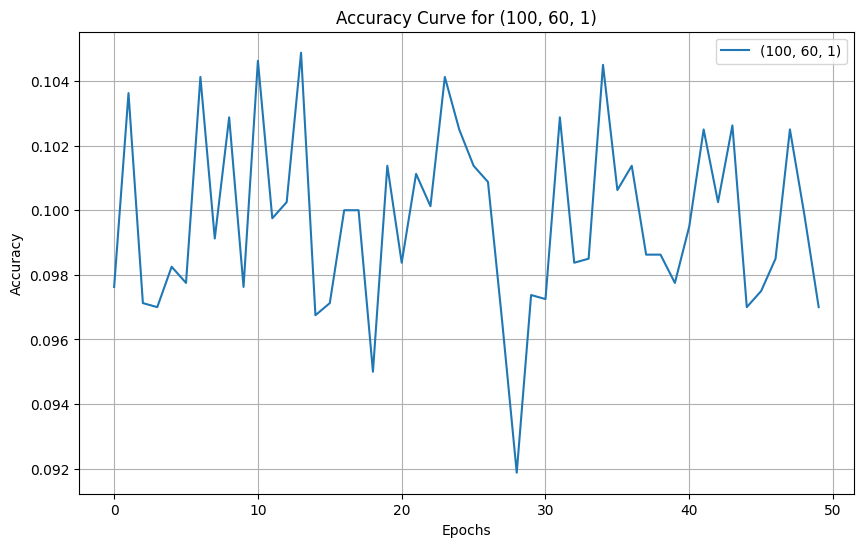

In [9]:
for key in accuracy_curves.keys():
    plt.figure(figsize=(10, 6))  # Create a new figure for each model
    plt.plot(accuracy_curves[key], label=f"{key}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curve for {key}")
    plt.grid(True)
    plt.legend()
    plt.show()



In [12]:
if results:
    df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
    print(df)
else:
    print("No results to display.")


   Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0     (160, 100)           0.01          10.55           81.690484
1     (160, 100)           0.10           9.55           83.161469
2     (160, 100)           1.00           9.75           90.304666
3     (100, 100)           0.01           9.80           89.256907
4     (100, 100)           0.10           9.75           93.542266
5     (100, 100)           1.00          10.65          112.662719
6     (100, 160)           0.01           9.85           87.643178
7     (100, 160)           0.10          10.65           90.481100
8     (100, 160)           1.00          10.25           94.458730
9       (60, 60)           0.01           9.15           95.696517
10      (60, 60)           0.10          10.50           98.543392
11      (60, 60)           1.00          10.65          103.998808
12     (100, 60)           0.01           9.75          106.904334
13     (100, 60)           0.10          10.10          110.91

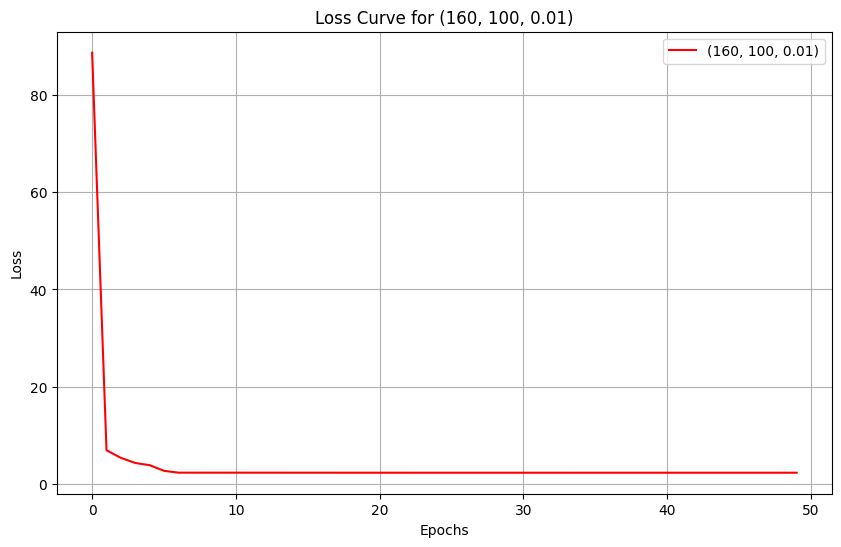

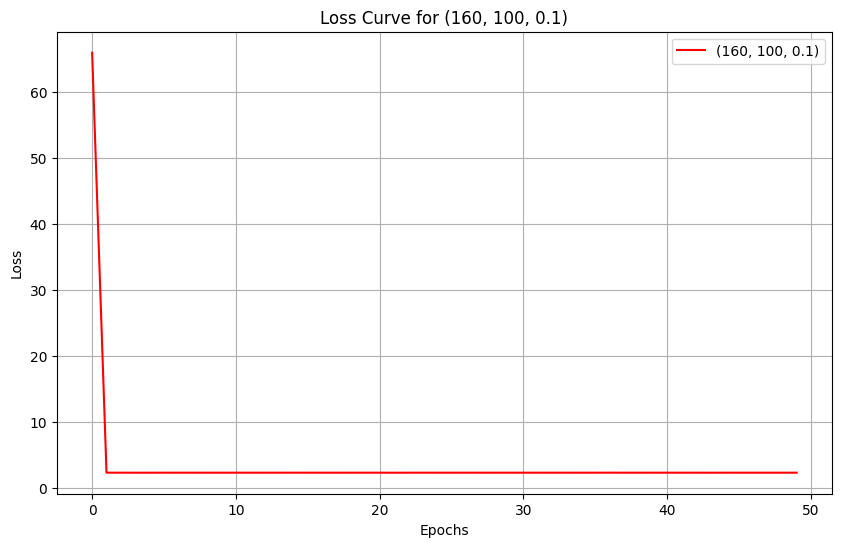

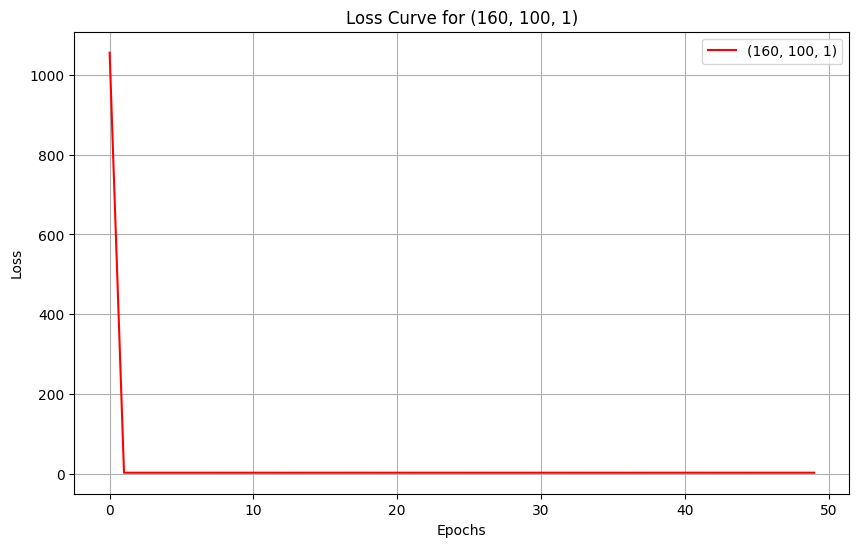

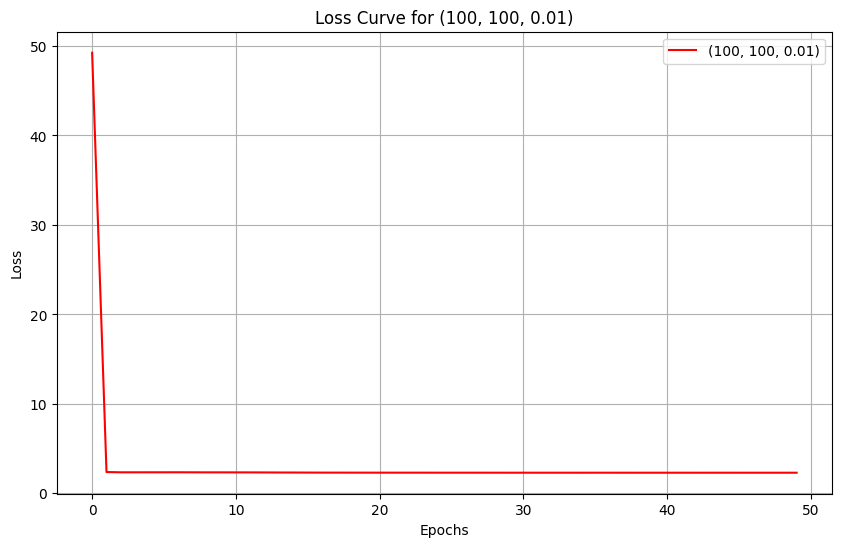

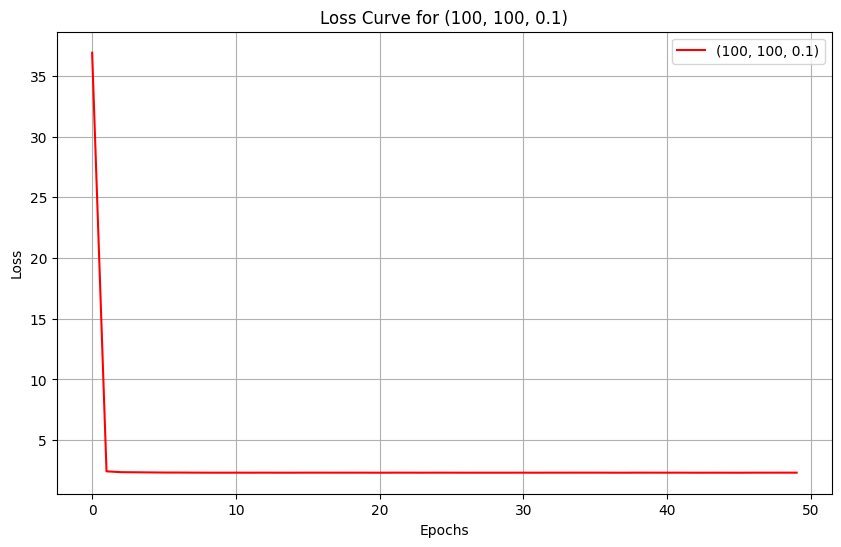

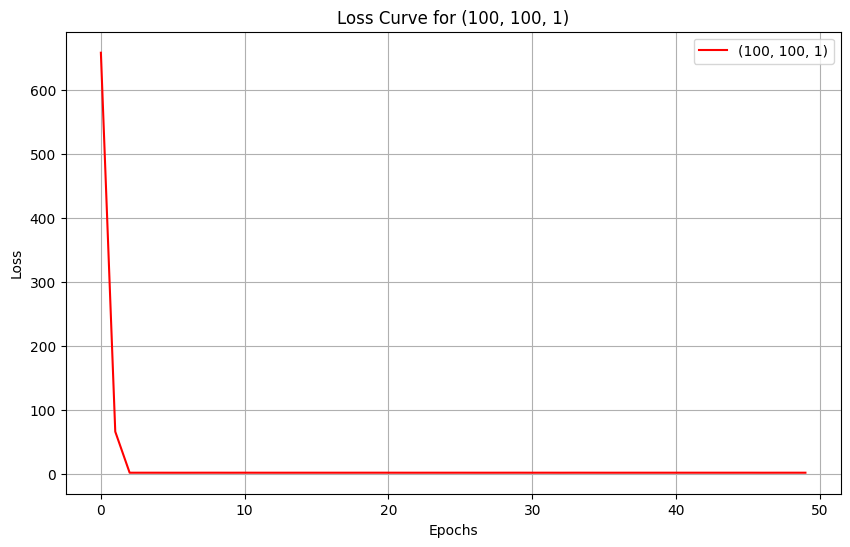

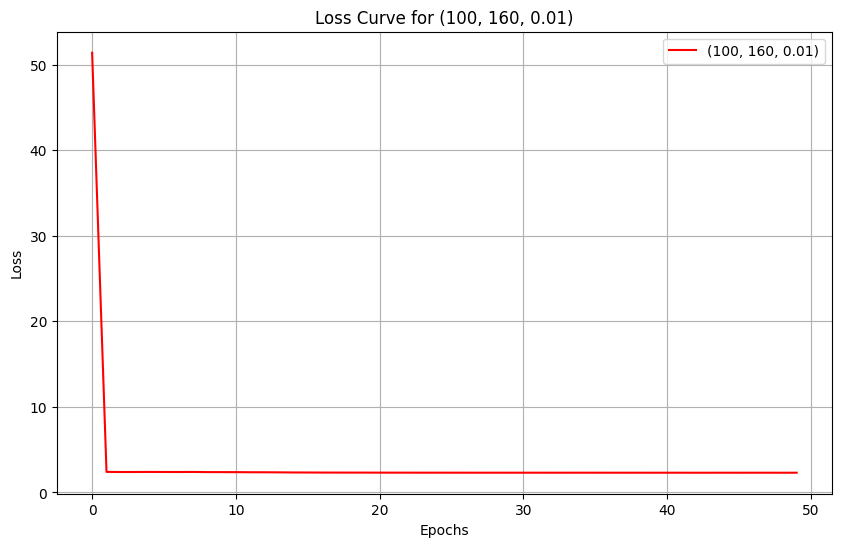

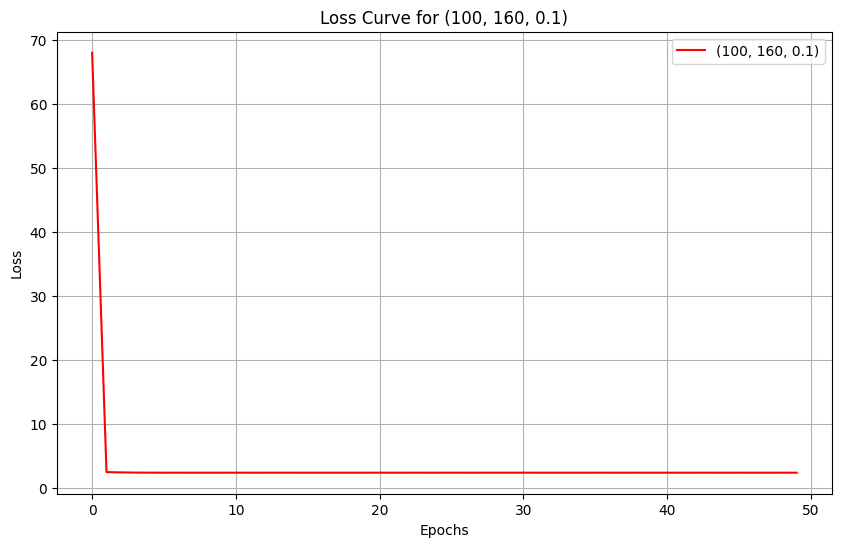

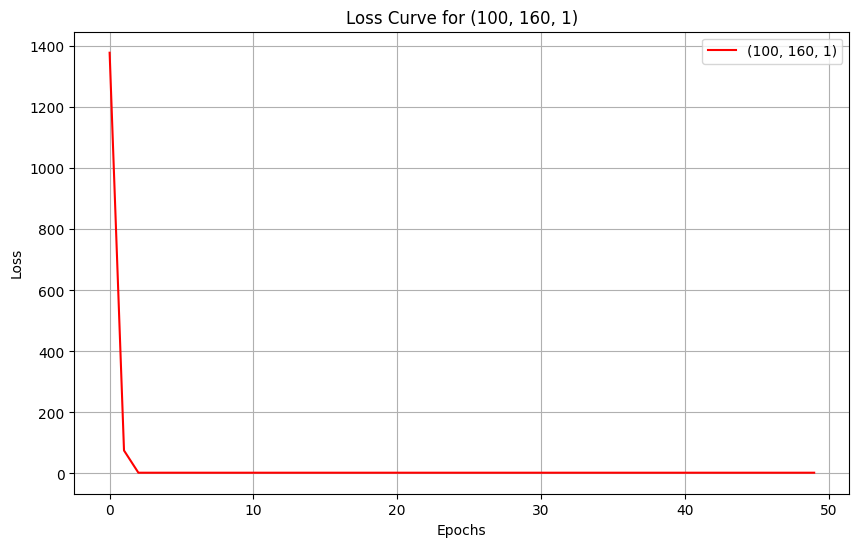

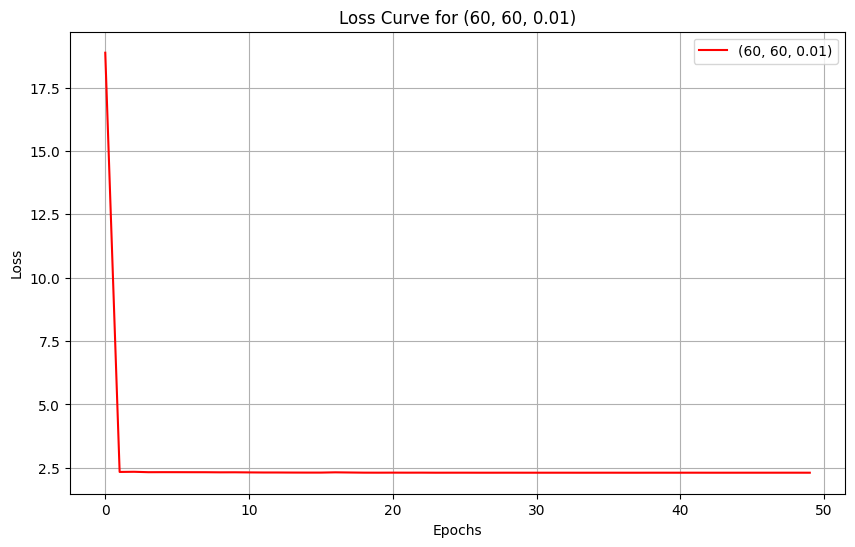

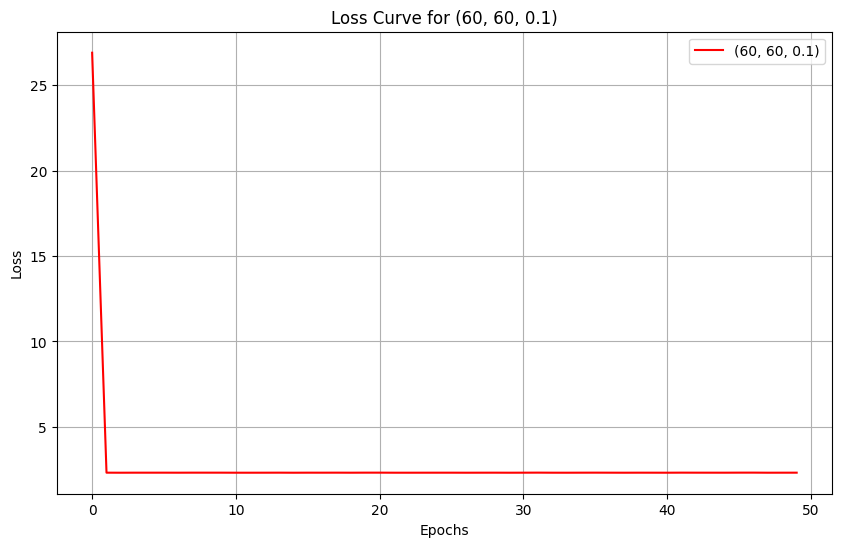

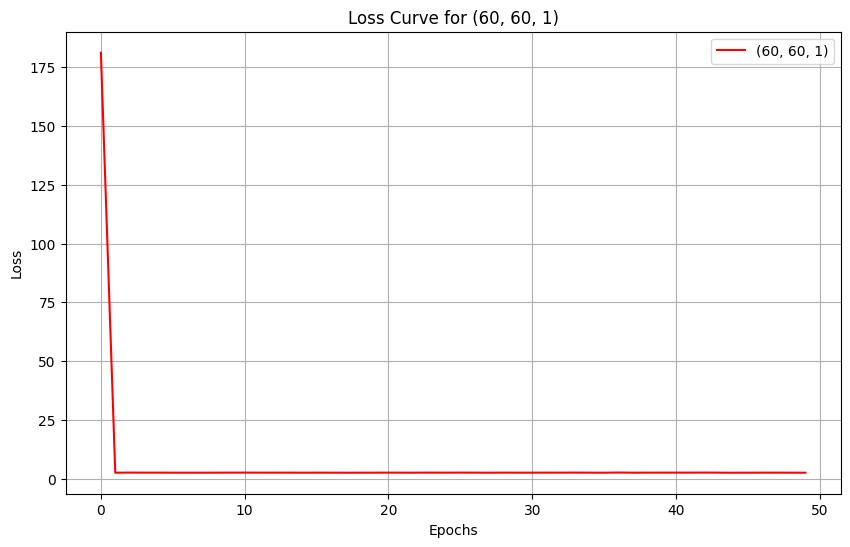

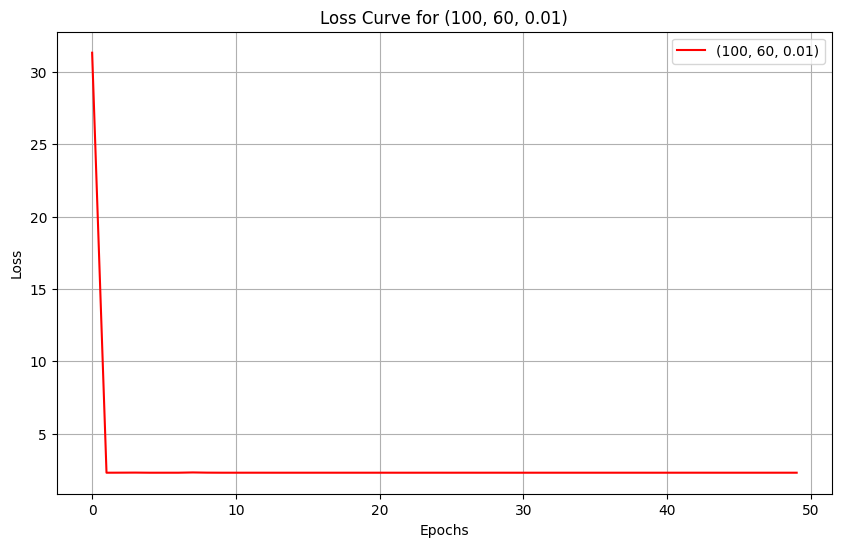

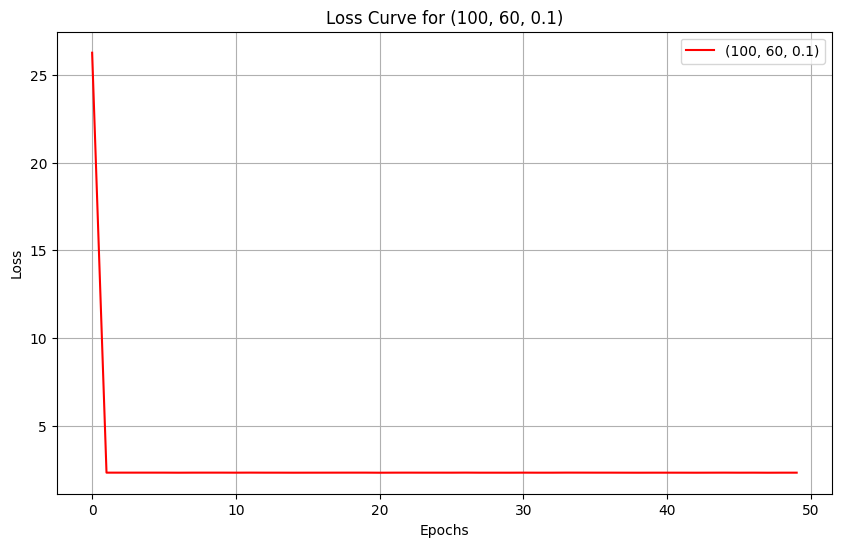

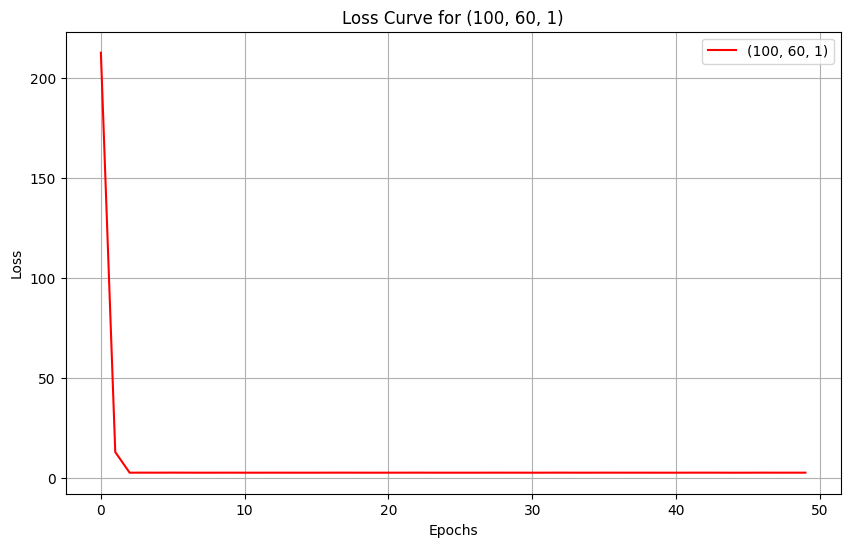

In [14]:
for key in loss_curves.keys():
    plt.figure(figsize=(10, 6))  # Create a new figure for each model
    plt.plot(loss_curves[key], label=f"{key}", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for {key}")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
#Comments:-
This model is a simple neural network for binary classification, testing different hyperparameters to find the best combination. 
Future improvements could include deeper architectures, better tuning, and real-world dataset applications.